In [2]:
# Imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

plt.rcParams.update({'font.size': 12,
                 'axes.spines.right': False,
                 'axes.spines.top': False,
                 'axes.linewidth':1.2,
                 'xtick.major.size': 6,
                 'xtick.major.width': 1.2,
                 'ytick.major.size': 6,
                 'ytick.major.width': 1.2,
                 'legend.frameon': False,
                 'legend.handletextpad': 0.1,
                 'figure.figsize': [10.0, 3.0],
                 'svg.fonttype': 'none',
                 'text.usetex': False})

In [355]:
# Load data 

Isteps_data = pd.read_excel('VO2_data_currents.xlsx',header=0)

# Extract relevant variables 
time = np.array(Isteps_data['Time'][2:])
Isteps = np.array(Isteps_data.iloc[1][1::4])
voltage_traces = np.array(Isteps_data.iloc[2:,1::4]).T
resistance_traces = np.array(Isteps_data.iloc[2:,2::4]).T
current_traces = np.array(Isteps_data.iloc[2:,3::4]).T

tau = np.zeros(len(Isteps))
for i,R in enumerate(resistance_traces):
    tau_R = (1-np.exp(-1)) * (R[-1]-R[0]) # value of R at the tau timepoint
    tau[i] = time[np.where(R>tau_R)[0][0]] # in seconds


## Simulation 1 (phenomenological)

In [192]:
# Define material properties of VO2 volatile resistors 

class Volatile_Resistor():
    def __init__(self, dt, temperature=70):
        self.dt = dt
        self.insulatorR = 5600
        self.metalR = 220
        self.R = self.insulatorR + self.metalR
        self.R_history = []
        self.controlI = 0
        self.controlI_history = []
        self.temperature = temperature
        self.peak_R = self.R
        
    def time_step(self):
        self.R_history.append(self.R)
        self.controlI_history.append(self.controlI)

        R_eq = self.transfer_func(self.controlI)         

        if self.R > R_eq:
            self.peak_R = R_eq
            rise_tau = np.maximum(self.dt, self.rise_tau(R=self.R, temperature=self.temperature))
            dRdt = (R_eq - self.R) / rise_tau
        else:
            decay_tau = np.maximum(self.dt, self.decay_tau(R=self.peak_R, temperature=self.temperature))    
            dRdt = (R_eq - self.R)**0.95 / decay_tau
            
        self.R += dRdt * self.dt
        
    def transfer_func(self, controlI):
        '''
        Function to convert between controlI and resistance
        controlI: current in units of mA
        '''        
        R_eq = self.insulatorR*np.exp(-0.12*controlI)+self.metalR # (Ohm)
        g_eq  = 1 / R_eq * 1e9 # convert to conductance (nS)
        return R_eq
    
    def inv_transfer_func(self, R):
        controlI = np.log((R-self.metalR)/self.insulatorR)/(-0.12)
        return controlI
        
    def decay_tau(self, controlI=None, R=None, temperature=70):
        if controlI is None:
            controlI = self.inv_transfer_func(R)
        tau = (0.02 * controlI**1.05) * np.exp(0.2*(temperature-70))
        tau = tau * 1e3 # convert to ms
        return tau 
    
    def rise_tau(self, R=None, temperature=70):
        tau = 1/(R+200) * np.exp(0.2*(temperature-72))
        tau = tau * 1e3 # convert to ms
        return tau
    
    @property
    def g(self):
        # Convert from resistance (Ohm) to conductance (nS)
        return 1e9/self.R
    
    
def VO2_test_pulse(dt, T, stim_time, temperature):
    '''
    Simulate a test pulse of a VO2 volatile resistor
    :param dt: time step (ms)
    :param T: simulation time (ms)
    '''

    time = np.arange(0., T, dt)

    R_hist_ls = []
    controlI_hist_ls = []
    for pulseI in np.arange(20,110,10):
        g_volatile = Volatile_Resistor(dt, temperature=temperature)
        for t in time:
            if t>stim_time[0] and t<stim_time[1]:
                g_volatile.controlI = pulseI  
            else:
                g_volatile.controlI = 0
            g_volatile.time_step()
        R_hist_ls.append(g_volatile.R_history)
        controlI_hist_ls.append(g_volatile.controlI_history)

    R_hist = np.array(R_hist_ls).T
    controlI_hist = np.array(controlI_hist_ls).T
    return time, R_hist, controlI_hist


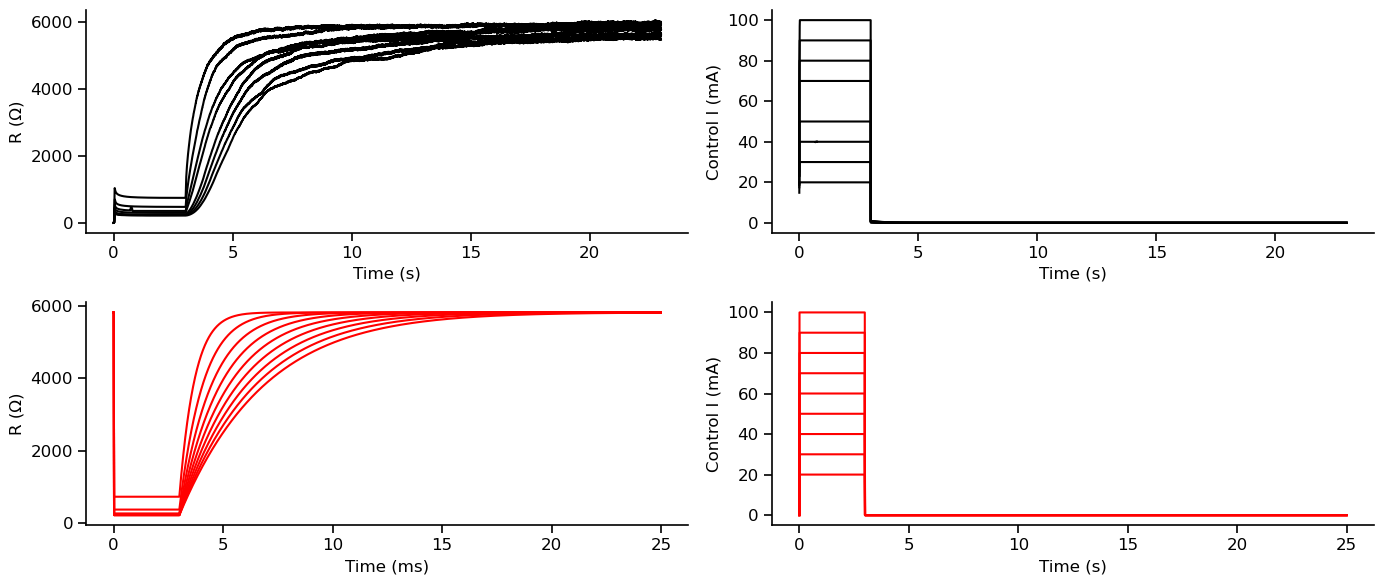

In [195]:
# Plot data vs simulation 

fig,ax = plt.subplots(2,2,figsize=[14,6])

for i,R in enumerate(resistance_traces):
    ax[0,0].plot(time, R, label=Isteps[i], c='k')
ax[0,0].set_xlabel('Time (s)')
ax[0,0].set_ylabel('R (Ω)')
# ax[0,0].set_xlim([1.,1.05])
# ax[0,0].set_ylim(top=5000)
 
for i,I in enumerate(current_traces):
    ax[0,1].plot(time, I*1000, label=Isteps[i], c='k')
ax[0,1].set_xlabel('Time (s)')
ax[0,1].set_ylabel('Control I (mA)')
# ax[0,1].legend()

sim_time, R_hist, controlI_hist = VO2_test_pulse(dt=10,T=25000, stim_time=(0,3000), temperature=70)
sim_time /= 1000
plot_nr = (1,0)
ax[plot_nr].plot(sim_time, R_hist, c='r')
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel('R (Ω)')
# ax[plot_nr].set_title('70°C')

ax[1,1].plot(sim_time, controlI_hist, 'r')
ax[1,1].set_xlabel('Time (s)')
ax[1,1].set_ylabel('Control I (mA)')

plt.tight_layout()
plt.show()

## Simulation 2 (mechanistic)

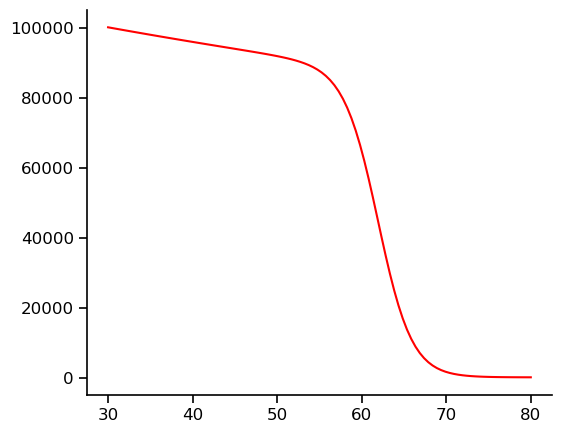

In [199]:
# Define material properties of VO2 volatile resistors 

class Volatile_Resistor():
    def __init__(self, dt, temperature=70):
        self.dt = dt
        self.R = self.sigmoid(temperature)
        self.controlI = 0
        self.internal_temp = temperature
        self.ambient_temp = temperature
        self.a = 0.001
        
        self.R_history = []
        self.controlI_history = [0]
        self.temp_history = [temperature]

    def sigmoid(self, temp, a=0.001):
        slow_component = 2.3e7/(temp+200)
        sigm = (1-a) / (1+np.exp((temp-75)/2)) + 0.001
        minR = 100
        R = slow_component*sigm + minR
        return R
    
    def time_step(self):
        # Increase the internal temperature of the device based on the applied current
#         dTemp = self.R*(self.controlI)**2.1 / 1e8
#         dTemp = (self.controlI) / 1e8
#         self.internal_temp = self.internal_temp + dTemp*self.dt
        target_temp = self.ambient_temp + self.controlI
        if target_temp > self.internal_temp:
            self.internal_temp = self.internal_temp + (target_temp - self.internal_temp)/100
        

        # Decay the internal temperature of the device exponentially towards ambient temperature
        dTemp = -1* (self.internal_temp - self.ambient_temp) / 7e2
        self.internal_temp = self.internal_temp + dTemp*self.dt
        
        # Compute heating transfer function (sigmoid)
        self.R = self.sigmoid(self.internal_temp)

        self.R_history.append(self.R)
        self.controlI_history.append(self.controlI)
        self.temp_history.append(self.internal_temp)
    
    @property
    def g(self):
        # Convert from resistance (Ohm) to conductance (nS)
        return 1e9/self.R

temp = np.linspace(30,80,100)
VO2 = Volatile_Resistor(dt=1)

fig, ax = plt.subplots(figsize=[6,5])
ax.plot(temp,VO2.sigmoid(temp),'r')
# ax.set_ylim(bottom=0, top = 5e4)
# ax.set_xlim([50,80])
plt.show()




a heat= 0.31446165860617536
a cool= 0.09531087079650864
a cool= 0.0351818708562784


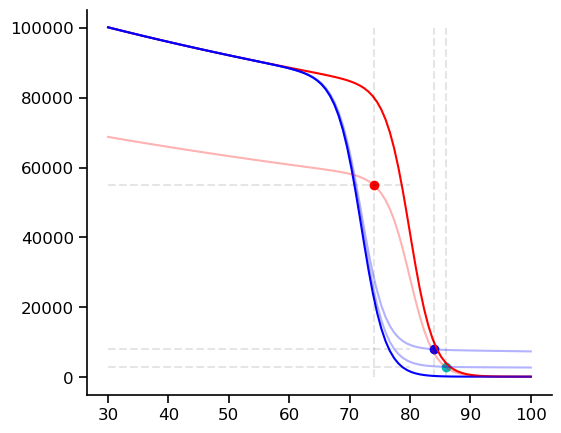

In [401]:
# Define material properties of VO2 volatile resistors 

class Volatile_Resistor():
    def __init__(self, dt, temperature=30):
        self.dt = dt
        self.R = self.heating_sigmoid(temperature)
        self.controlI = 0
        self.internal_temp = temperature
        self.ambient_temp = temperature
        self.heating = 1
        self.a = 0.001
        
        self.R_history = []
        self.controlI_history = [0]
        self.temp_history = [temperature]

    def heating_sigmoid(self, temp, a=0.001):
        slow_component = 2.3e7/(temp+200)
        sigm = (1-a) / (1+np.exp((temp-80)/2)) + 0.001
        minR = 100
        R = slow_component*sigm + minR
        return R

    def get_heating_sigmoid_coeff(self, temp,R):
        slow_component = 2.3e7/(temp+200)
        minR = 100
        a = ((minR - R)/slow_component + 0.001) * (1+np.exp((temp-80)/2)) + 1
        return a

    def cooling_sigmoid(self, temp, a=0.001):
        slow_component = 2.3e7/(temp+200)
        sigm = (1-a) / (1+np.exp((temp-72)/2)) + a
        minR = 100
        R = slow_component*sigm + minR
        return R
    
    def get_cooling_sigmoid_coeff(self, temp,R):
        slow_component = 2.3e7/(temp+200)
        sigm_denominator = (1+np.exp((temp-72)/2))
        minR = 100
        a = (sigm_denominator*(R - minR)/slow_component - 1)/(sigm_denominator -1 +1e-10)
        return a
    
    def time_step(self):

        # Increase the internal temperature of the device based on the applied current
        target_temp = self.ambient_temp + self.controlI
        if target_temp > self.internal_temp:
            self.internal_temp = self.internal_temp + (target_temp - self.internal_temp)/100
        

        # Decay the internal temperature of the device exponentially towards ambient temperature
        dTemp = -1* (self.internal_temp - self.ambient_temp) / 9e2
        self.internal_temp = self.internal_temp + dTemp*self.dt
        
        # Compute heating transfer function (sigmoid)
        if self.internal_temp >= self.temp_history[-1]: # if heating
            if self.heating == 0: #if temperature changed direction, recompute sigmoid
                self.a = self.get_heating_sigmoid_coeff(self.temp_history[-1], self.R)
                print('Heating!', self.internal_temp)
                assert (self.a>=0 and self.a<=1), f'Heating sigmoid out of bounds: a={self.a} T={self.temp_history[-1]}, R={self.R}'
                self.heating = 1
            self.R = self.heating_sigmoid(self.internal_temp, self.a)
        
        # Compute cooling transfer function (sigmoid)
        elif self.internal_temp < self.temp_history[-1]: #if cooling
            if self.heating == 1: #if temperature changed direction, recompute sigmoid
                self.a = self.get_cooling_sigmoid_coeff(self.temp_history[-1], self.R)
                #print('Cooling!', self.internal_temp, self.a)
                assert (self.a>=0 and self.a<=1), f'Cooling sigmoid out of bounds: a={self.a} T={self.temp_history[-1]}, R={self.R}'
                self.heating = 0
            self.R = self.cooling_sigmoid(self.internal_temp, self.a)
                
        self.R_history.append(self.R)
        self.controlI_history.append(self.controlI)
        self.temp_history.append(self.internal_temp)
    
    @property
    def g(self):
        # Convert from resistance (Ohm) to conductance (nS)
        return 1e9/self.R


temp = np.linspace(30,100,100)
VO2 = Volatile_Resistor(dt=1)

coord1 = (74, 5.5e4)
coord2 = (84, 8e3)
coord3 = (86, 3e3)

func1 = VO2.heating_sigmoid(temp)
a = VO2.get_heating_sigmoid_coeff(temp=coord1[0],R=coord1[1])
print(f'a heat= {a}')
func2 = VO2.heating_sigmoid(temp, a)

func3 = VO2.cooling_sigmoid(temp)
a = VO2.get_cooling_sigmoid_coeff(temp=coord2[0],R=coord2[1])
print(f'a cool= {a}')
func4 = VO2.cooling_sigmoid(temp, a)

a = VO2.get_cooling_sigmoid_coeff(temp=coord3[0],R=coord3[1])
print(f'a cool= {a}')
func5 = VO2.cooling_sigmoid(temp, a)

fig, ax = plt.subplots(figsize=[6,5])
ax.plot(temp,func1,'r')
ax.plot(temp,func3,'b')

ax.plot(temp,func2,'r', alpha=0.3)
ax.plot(temp,func4,'b', alpha=0.3)
ax.plot(temp,func5,'b', alpha=0.3)

ax.scatter(coord1[0],coord1[1],c='r')
ax.plot([coord1[0],coord1[0]],[0,1e5],'k--',alpha=0.1)
ax.plot([30,80],[coord1[1],coord1[1]],'k--',alpha=0.1)

ax.scatter(coord2[0],coord2[1],c='b')
ax.plot([coord2[0],coord2[0]],[0,1e5],'k--',alpha=0.1)
ax.plot([30,80],[coord2[1],coord2[1]],'k--',alpha=0.1)

ax.scatter(coord3[0],coord3[1],c='c')
ax.plot([coord3[0],coord3[0]],[0,1e5],'k--',alpha=0.1)
ax.plot([30,80],[coord3[1],coord3[1]],'k--',alpha=0.1)

# ax.set_ylim(bottom=0, top = 5e4)
# ax.set_xlim([50,80])
plt.show()

a heat= 0.31446165860617536
a cool= 0.09020902090209021
a cool= 0.027002700270027005


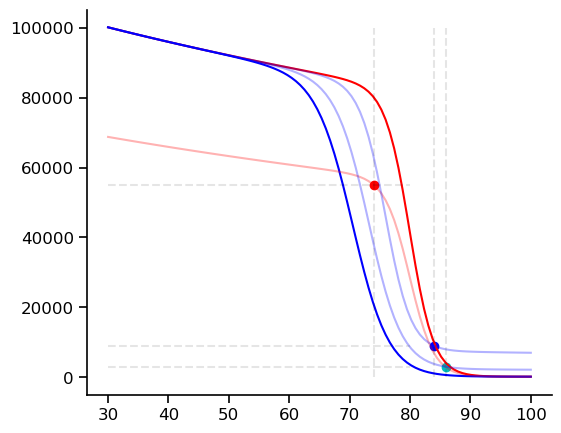

In [397]:
# Define material properties of VO2 volatile resistors 

class Volatile_Resistor():
    def __init__(self, dt, temperature=30):
        self.dt = dt
        self.R = self.heating_sigmoid(temperature)
        self.controlI = 0
        self.internal_temp = temperature
        self.ambient_temp = temperature
        self.heating = 1
        self.a = 0.001
        
        self.R_history = []
        self.controlI_history = [0]
        self.temp_history = [temperature]

    def heating_sigmoid(self, temp, a=0.001):
        slow_component = 2.3e7/(temp+200)
        sigm = (1-a) / (1+np.exp((temp-80)/2)) + 0.001
        minR = 100
        R = slow_component*sigm + minR
        return R

    def get_heating_sigmoid_coeff(self, temp,R):
        slow_component = 2.3e7/(temp+200)
        minR = 100
        a = ((minR - R)/slow_component + 0.001) * (1+np.exp((temp-80)/2)) + 1
        return a

    def cooling_sigmoid(self, temp, a=0.001):
        slow_component = 2.3e7/(temp+200)
        transition_temp = 70 + 20*a**0.5
        sigm = (1-a) / (1+np.exp((temp-transition_temp)/(3-10*a))) + a
        minR = 100
        R = slow_component*sigm + minR
        return R

    def get_cooling_sigmoid_coeff(self, temp, R):
        '''
        Scan through coefficients until the closest match is found
        '''
        for a in np.linspace(0,1,10000):
            computed_R = self.cooling_sigmoid(temp, a)
            if computed_R > R:
                break
        return a
    
    def time_step(self):
        # Increase the internal temperature of the device based on the applied current
        target_temp = self.ambient_temp + self.controlI
        if target_temp > self.internal_temp:
            self.internal_temp = self.internal_temp + (target_temp - self.internal_temp)/100
        
        # Decay the internal temperature of the device exponentially towards ambient temperature
        dTemp = -1* (self.internal_temp - self.ambient_temp) / 9e2
        self.internal_temp = self.internal_temp + dTemp*self.dt
        
        # Compute heating transfer function (sigmoid)
        if self.internal_temp >= self.temp_history[-1]: # if heating
            if self.heating == 0: #if temperature changed direction, recompute sigmoid
                self.a = self.get_heating_sigmoid_coeff(self.temp_history[-1], self.R)
                print('Heating!', self.internal_temp)
                assert (self.a>=0 and self.a<=1), f'Heating sigmoid out of bounds: a={self.a} T={self.temp_history[-1]}, R={self.R}'
                self.heating = 1
            self.R = self.heating_sigmoid(self.internal_temp, self.a)
        
        # Compute cooling transfer function (sigmoid)
        elif self.internal_temp < self.temp_history[-1]: #if cooling
            if self.heating == 1: #if temperature changed direction, recompute sigmoid
                self.a = self.get_cooling_sigmoid_coeff(self.temp_history[-1], self.R)
                #print('Cooling!', self.internal_temp, self.a)
                assert (self.a>=0 and self.a<=1), f'Cooling sigmoid out of bounds: a={self.a} T={self.temp_history[-1]}, R={self.R}'
                self.heating = 0
            self.R = self.cooling_sigmoid(self.internal_temp, self.a)
                
        self.R_history.append(self.R)
        self.controlI_history.append(self.controlI)
        self.temp_history.append(self.internal_temp)
    
    @property
    def g(self):
        # Convert from resistance (Ohm) to conductance (nS)
        return 1e9/self.R


temp = np.linspace(30,100,100)
VO2 = Volatile_Resistor(dt=1)

coord1 = (74, 5.5e4)
coord2 = (84, 9e3)
coord3 = (86, 3e3)

func1 = VO2.heating_sigmoid(temp)
a = VO2.get_heating_sigmoid_coeff(temp=coord1[0],R=coord1[1])
print(f'a heat= {a}')
func2 = VO2.heating_sigmoid(temp, a)

func3 = VO2.cooling_sigmoid(temp)
a = VO2.get_cooling_sigmoid_coeff(temp=coord2[0],R=coord2[1])
print(f'a cool= {a}')
func4 = VO2.cooling_sigmoid(temp, a)

a = VO2.get_cooling_sigmoid_coeff(temp=coord3[0],R=coord3[1])
print(f'a cool= {a}')
func5 = VO2.cooling_sigmoid(temp, a)

fig, ax = plt.subplots(figsize=[6,5])
ax.plot(temp,func1,'r')
ax.plot(temp,func3,'b')

ax.plot(temp,func2,'r', alpha=0.3)
ax.plot(temp,func4,'b', alpha=0.3)
ax.plot(temp,func5,'b', alpha=0.3)

ax.scatter(coord1[0],coord1[1],c='r')
ax.plot([coord1[0],coord1[0]],[0,1e5],'k--',alpha=0.1)
ax.plot([30,80],[coord1[1],coord1[1]],'k--',alpha=0.1)

ax.scatter(coord2[0],coord2[1],c='b')
ax.plot([coord2[0],coord2[0]],[0,1e5],'k--',alpha=0.1)
ax.plot([30,80],[coord2[1],coord2[1]],'k--',alpha=0.1)

ax.scatter(coord3[0],coord3[1],c='c')
ax.plot([coord3[0],coord3[0]],[0,1e5],'k--',alpha=0.1)
ax.plot([30,80],[coord3[1],coord3[1]],'k--',alpha=0.1)

# ax.set_ylim(bottom=0, top = 5e4)
# ax.set_xlim([50,80])
plt.show()

In [402]:
def VO2_test_pulse(dt, T, stim_time, temperature):
    '''
    Simulate a test pulse of a VO2 volatile resistor
    :param dt: time step (ms)
    :param T: simulation time (ms)
    '''
    dt = 1
    time = np.arange(0., T, dt)

    R_hist_ls = []
    controlI_hist_ls = []
    temp_hist_ls = []
    for pulseI in np.arange(20,110,10):
        g_volatile = Volatile_Resistor(dt, temperature=temperature)
        for t in time:
            if t>stim_time[0] and t<stim_time[1]:
                g_volatile.controlI = pulseI  
            else:
                g_volatile.controlI = 0
            g_volatile.time_step()
        R_hist_ls.append(g_volatile.R_history)
        controlI_hist_ls.append(g_volatile.controlI_history[1:])
        temp_hist_ls.append(g_volatile.temp_history[1:])

    R_hist = np.array(R_hist_ls).T
    controlI_hist = np.array(controlI_hist_ls).T
    temp_hist = np.array(temp_hist_ls).T
    return time, R_hist, controlI_hist, temp_hist


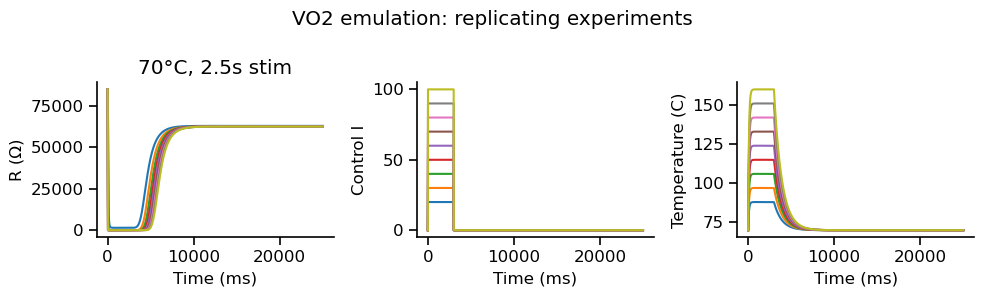

In [403]:
# Plot test pulses: replicating experiments 
fig,ax = plt.subplots(1,3,figsize=[10,3])

sim_time, R_hist, controlI_hist, temp_hist = VO2_test_pulse(dt=1,T=25000, stim_time=(0,3000), temperature=70)
ax[0].plot(sim_time, R_hist)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('R (Ω)')
ax[0].set_title('70°C, 2.5s stim')
# ax[0].set_ylim([0,2e4])

ax[1].plot(sim_time, controlI_hist)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Control I')

ax[2].plot(sim_time, temp_hist)
ax[2].set_xlabel('Time (ms)')
ax[2].set_ylabel('Temperature (C)')
# ax[2].set_ylim([30,100])

plt.suptitle('VO2 emulation: replicating experiments')

plt.tight_layout()
plt.show()

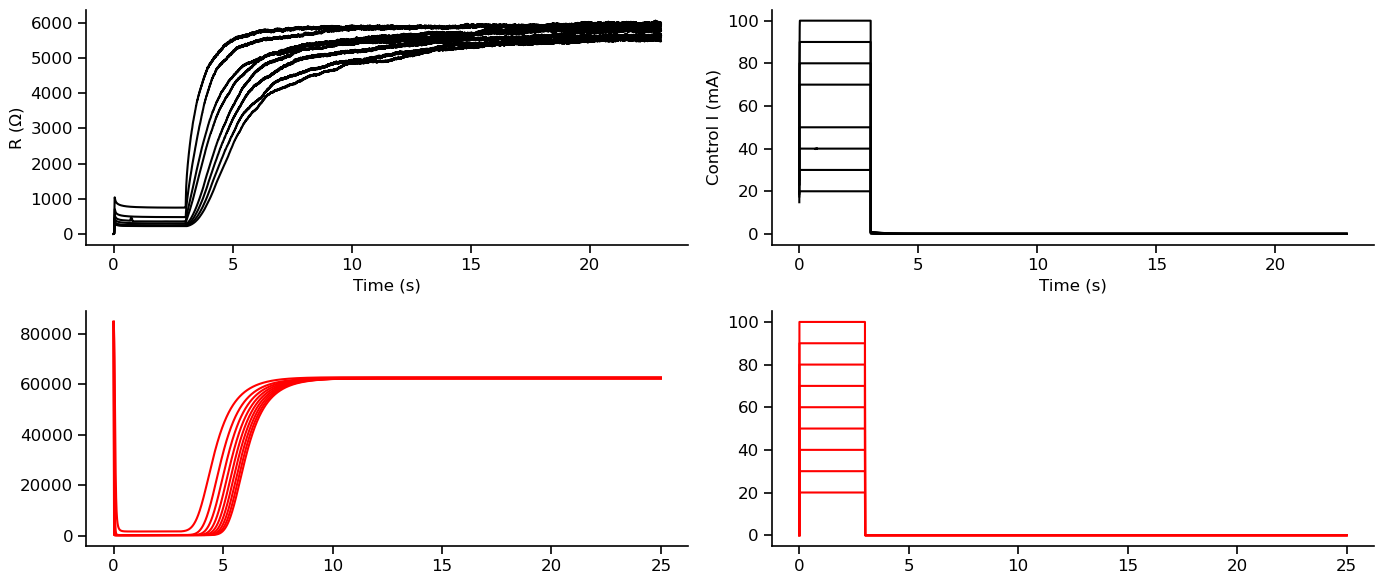

In [404]:
# Plot data vs simulation 

fig,ax = plt.subplots(2,2,figsize=[14,6])

for i,R in enumerate(resistance_traces):
    ax[0,0].plot(time, R, label=Isteps[i], c='k')
ax[0,0].set_xlabel('Time (s)')
ax[0,0].set_ylabel('R (Ω)')
# ax[0,0].set_xlim([1.,1.05])
# ax[0,0].set_ylim(top=5000)
 
for i,I in enumerate(current_traces):
    ax[0,1].plot(time, I*1000, label=Isteps[i], c='k')
ax[0,1].set_xlabel('Time (s)')
ax[0,1].set_ylabel('Control I (mA)')
# ax[0,1].legend()

sim_time, R_hist, controlI_hist, temp_hist = VO2_test_pulse(dt=1,T=25000, stim_time=(0,3000), temperature=70)
sim_time /= 1000
ax[1,0].plot(sim_time, R_hist, c='r')
ax[1,1].plot(sim_time, controlI_hist, c='r')

plt.tight_layout()
plt.show()